In [1]:
# Import Dependencies
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image

from keras.preprocessing import image
from keras.datasets import mnist
from keras import optimizers
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Lambda, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau





In [2]:
# Set up Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change Directory
%cd '/content/drive/MyDrive/Data_analytics /group_project_4/pet_expressions_data'

/content/drive/MyDrive/Data_analytics /group_project_4/pet_expressions_data


In [3]:
# Define the path to the dataset folders
happy_folder = "/content/drive/MyDrive/Data_analytics /group_project_4/pet_expressions_data/happy"
sad_folder = "/content/drive/MyDrive/Data_analytics /group_project_4/pet_expressions_data/sad"
angry_folder = "/content/drive/MyDrive/Data_analytics /group_project_4/pet_expressions_data/angry"
other_folder = "/content/drive/MyDrive/Data_analytics /group_project_4/pet_expressions_data/other"

In [4]:
# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))  # Resize to a fixed size for the model
            images.append(img)
    return images

In [5]:
# Load images and labels for each emotion
happy_images = load_images_from_folder(happy_folder)
sad_images = load_images_from_folder(sad_folder)
angry_images = load_images_from_folder(angry_folder)
other_images = load_images_from_folder(other_folder)

In [6]:
# Check shape, 3 means it is in RGB format
happy_images[1].shape

(224, 224, 3)

In [7]:
# Create labels for each emotion category
happy_labels = [0] * len(happy_images)
sad_labels = [1] * len(sad_images)
angry_labels = [2] * len(angry_images)
other_labels = [3] * len(other_images)

In [8]:
# Concatenate images and labels
x = np.array(happy_images + sad_images + angry_images + other_images)
y = np.array(happy_labels + sad_labels + angry_labels + other_labels)

In [9]:
# Normalize pixel values to range [0, 1]
x = x.astype('float32') / 255.0

In [10]:
# One-hot encode the labels
y = tf.keras.utils.to_categorical(y, 4)

In [11]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

In [ ]:
# Split again into a validation set
# x_validate, x_test, y_validate, y_test= train_test_split (x_test,y_test, test_size=.50, random_state=100)

In [12]:
# Reshape the images to (224, 224, 3)
x_train = np.array([cv2.resize(image, (224, 224)) for image in x_train])
# x_validate = np.array([cv2.resize(image, (224, 224)) for image in x_validate])

In [13]:
print (f' x train',x_train.shape)
print (f' x test', x_test.shape)
print (f' y train', y_train.shape)
print (f' y test', y_test.shape)
# print (f' x validate', x_validate.shape)
# print (f' y validate', y_validate.shape)

 x train (296, 224, 224, 3)
 x test (74, 224, 224, 3)
 y train (296, 4)
 y test (74, 4)


In [36]:
# from skopt import gp_minimize
# from skopt.space import Real

# #Create function to optimize the model and find the best learning rate
# def objective(learning_rate):
#     # Compile and train VGG16 model using the given learning rate
#     model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
#                   loss='binary_crossentropy',
#                   metrics=['acc'])
#     history = model.fit(...)

#     # Return negative validation accuracy (to minimize) or validation loss (to maximize)
#     return -history.history['val_acc'][-1]

# # Define the search space for the learning rate
# space = Real(low=1e-6, high=1e-2, prior='log-uniform')

# # Perform Bayesian optimization
# result = gp_minimize(objective, dimensions=[space], n_calls=10)

# # Retrieve the best learning rate
# best_learning_rate = result.x[0]


In [14]:
#here [3] denotes for RGB images(3 channels)
# Set the paramaters for the vgg16 model
Image_size = [224, 224]
vgg = VGG16(input_shape= Image_size + [3], weights='imagenet', include_top=False)

#don't train existing weights
for layer in vgg.layers:
 layer.trainable = False

# Set the inputs and outputs for the model
x = Flatten()(vgg.output)
prediction = Dense(4, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

#compile according to standard metrics found on the internet
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])
# model.summary()

In [17]:
# Establish early stopping"
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)


In [18]:
# Create an ImageDataGenerator for training with data augmentation
# This includes a validation split set at 0.5
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.5
)

# Create a generator for training data
batch_size = 10
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size,
    subset='training'  # Specify that this is the training subset
)

# Create a generator for validation data
validation_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size,
    subset='validation'  # Specify that this is the validation subset
)

In [20]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, lr_scheduler],
    epochs=10
)

Epoch 1/10
15/15 [==============================] - 242s 17s/step - loss: 0.5932 - acc: 0.3108 - val_loss: 0.5561 - val_acc: 0.3243 - lr: 1.0000e-04
Epoch 2/10
15/15 [==============================] - 238s 16s/step - loss: 0.5587 - acc: 0.3108 - val_loss: 0.5606 - val_acc: 0.2568 - lr: 1.0000e-04
Epoch 3/10
15/15 [==============================] - 243s 17s/step - loss: 0.5625 - acc: 0.3041 - val_loss: 0.5662 - val_acc: 0.3243 - lr: 1.0000e-04
Epoch 4/10
15/15 [==============================] - 238s 17s/step - loss: 0.5584 - acc: 0.2770 - val_loss: 0.5626 - val_acc: 0.2432 - lr: 1.0000e-04
Epoch 5/10
15/15 [==============================] - 238s 17s/step - loss: 0.5632 - acc: 0.2500 - val_loss: 0.5558 - val_acc: 0.3243 - lr: 1.0000e-04
Epoch 6/10
15/15 [==============================] - 251s 18s/step - loss: 0.5610 - acc: 0.3176 - val_loss: 0.5642 - val_acc: 0.2432 - lr: 1.0000e-04
Epoch 7/10
15/15 [==============================] - 237s 17s/step - loss: 0.5590 - acc: 0.3176 - val_loss:

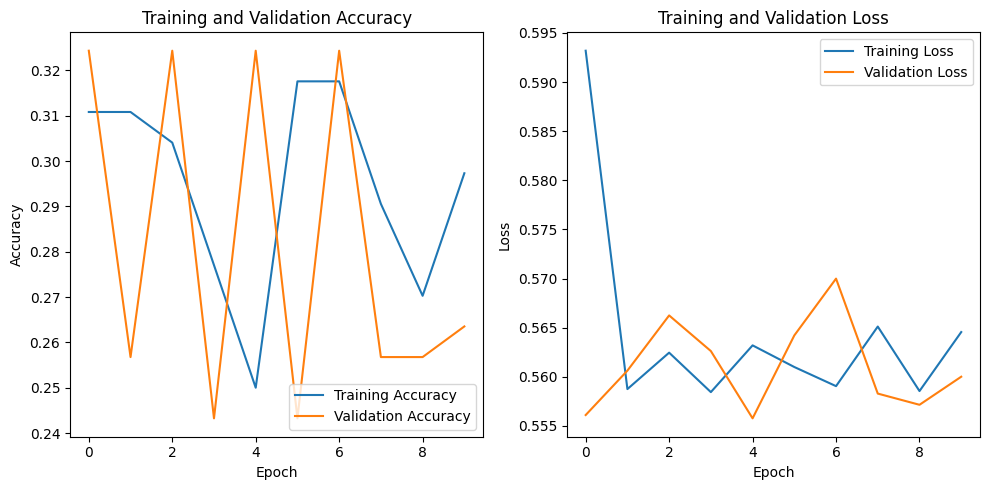

In [21]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Fit the model
###################################################################################
# Need to check the size of the validation datasets
# Need to be Make sure that  dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches)
# history = model.fit(
#                     x_train, y_train,
#                     epochs = 10, verbose=1,
#                     validation_data = (x_validate, y_validate),
#                     validation_steps = 20)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.5634 - acc: 0.3311 

10/10 [==============================] - 240s 24s/step - loss: 0.5634 - acc: 0.3311 - val_loss: 0.6999 - val_acc: 0.1351
Epoch 2/10
10/10 [==============================] - 194s 19s/step - loss: 0.5056 - acc: 0.4899
Epoch 3/10
10/10 [==============================] - 187s 19s/step - loss: 0.4793 - acc: 0.5304
Epoch 4/10
10/10 [==============================] - 190s 19s/step - loss: 0.4531 - acc: 0.5845
Epoch 5/10
10/10 [==============================] - 188s 19s/step - loss: 0.4308 - acc: 0.6622
Epoch 6/10
10/10 [==============================] - 193s 19s/step - loss: 0.4102 - acc: 0.6655
Epoch 7/10
10/10 [==============================] - 189s 19s/step - loss: 0.3910 - acc: 0.7196
Epoch 8/10
10/10 [==============================] - 190s 19s/step - loss: 0.3729 - acc: 0.7399
Epoch 9/10
10/10 [==============================] - 189s 19s/step - loss: 0.3577 - acc: 0.8142
Epoch 10/10
10/10 [==============================] - 189s 19s/step - loss: 0.3458 - acc: 0.8007


In [ ]:
# Evaluate the model on the train data
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=2)
print("Train Accuracy:", train_accuracy)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("Test Accuracy:", test_accuracy)

10/10 - 204s - loss: 0.3300 - acc: 0.7804 - 204s/epoch - 20s/step
Train Accuracy: 0.7804054021835327
2/2 - 22s - loss: 0.4586 - acc: 0.5676 - 22s/epoch - 11s/step
Test Accuracy: 0.5675675868988037


In [ ]:
# Save the trained model
model.save("pet_expressions_model_vgg16.h5")

In [ ]:
##################################################################################

In [ ]:
# Load the saved model

loaded_model = load_model("pet_expressions_model.h5")

In [ ]:
# Function to load and preprocess images

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (48, 48))  # Resize to a fixed size for the model
            images.append(img)
    return images

In [ ]:
# Load a custom test image

custom_test_image_path = "/kaggle/input/pets-facial-expression-dataset/Angry/16924834.jpg"

custom_test_image = cv2.imread(custom_test_image_path)
custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (48, 48))
custom_test_image = custom_test_image.astype('float32') / 255.0

In [ ]:
# Reshape the image to match the model input shape

custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

In [ ]:
# Make predictions on the custom test image

prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

In [ ]:
emotion_label = np.argmax(prediction[0])

In [ ]:
# Map the predicted label to emotion class

emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

In [ ]:
# Print the custom test image and its predicted label

print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

In [ ]:
#Display the custom test image using matplotlib

plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
# Display the original custom test image using PIL

img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()